In [1]:
import keras
import numpy as np
from keras.datasets import mnist
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Baby's first Autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder.

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Let's also create a separate encoder model.

In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

We'll also make a decoder model here too.

In [4]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

We'll normalise all the values between 0 and 1, and we'll flatten the 28x28 images into vectors of size 784 (by concatenation of the rows.)

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


Now we'll train the autoencoder for 50 epochs.

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.3677 - val_loss: 0.2715
Epoch 2/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2641 - val_loss: 0.2525
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2418 - val_loss: 0.2289
Epoch 4/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2219 - val_loss: 0.2123
Epoch 5/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2077 - val_loss: 0.2003
Epoch 6/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1970 - val_loss: 0.1911
Epoch 7/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.1886 - val_loss: 0.1836
Epoch 8/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1818 - val_loss: 0.1774
Epoch 9/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1762 - val_loss: 0.1723
Epoch

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.11. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

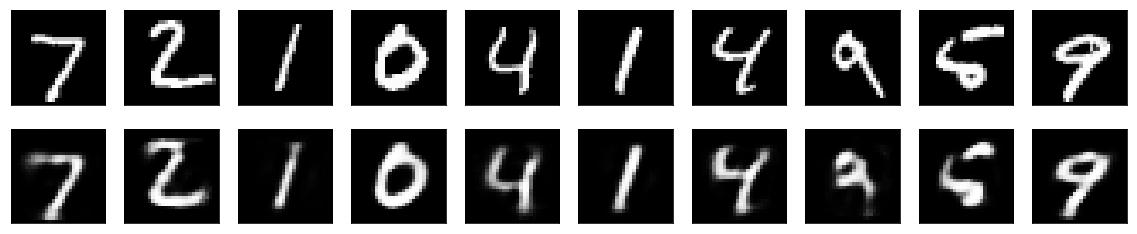

In [10]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
encoded_imgs.mean()

7.1447687

## Adding a Sparsity Constraint on encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an `activity_regularizer` to our Dense layer:

In [12]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its encoded representation
autoencoder = Model(input_img, decoded)


encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

We'll train this model for 100 epochs with the regulariser included. This will make the model less prone to overfitting; it can also be trained for longer. We'll visualise the results while we're at it.

In [13]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.6736 - val_loss: 0.6485
Epoch 2/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.4531 - val_loss: 0.4

60000/60000 [==============================] - 1s 22us/step - loss: 0.2828 - val_loss: 0.2826
Epoch 78/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2825 - val_loss: 0.2823
Epoch 79/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2822 - val_loss: 0.2820
Epoch 80/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2819 - val_loss: 0.2817
Epoch 81/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2816 - val_loss: 0.2814
Epoch 82/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2813 - val_loss: 0.2812
Epoch 83/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2810 - val_loss: 0.2809
Epoch 84/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2808 - val_loss: 0.2806
Epoch 85/100
60000/60000 [==============================] - 1s 22us/step - loss: 0.2805 - val_loss: 0.2804
Epoch 86/100
60000/60000 [========================

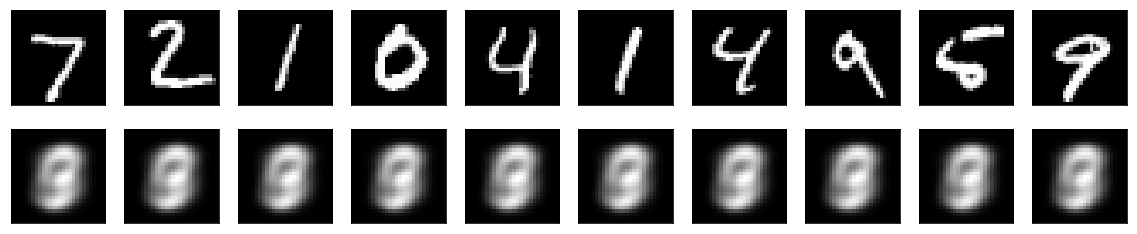

In [14]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It should look similar to the previous model, but the difference should be in the sparsity of the encoded representations.

In [15]:
encoded_imgs.mean()

1.3924803e-06

## Deep Autoencoders

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [16]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.3597 - val_loss: 0.2638
Epoch 2/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.2587 - val_loss: 0.2533
Epoch 3/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.2438 - val_loss: 0.2308
Epoch 4/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.2260 - val_loss: 0.2214
Epoch 5/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.2174 - val_loss: 0.2107
Epoch 6/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.2049 - val_loss: 0.1974
Epoch 7/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1926 - val_loss: 0.1856
Epoch 8/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1828 - val_loss: 0.1792
Epoch 9/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1758 - val_loss: 0.1

60000/60000 [==============================] - 2s 31us/step - loss: 0.1064 - val_loss: 0.1054
Epoch 78/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1062 - val_loss: 0.1062
Epoch 79/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1060 - val_loss: 0.1044
Epoch 80/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1058 - val_loss: 0.1046
Epoch 81/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1055 - val_loss: 0.1036
Epoch 82/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1053 - val_loss: 0.1060
Epoch 83/100
60000/60000 [==============================] - 2s 29us/step - loss: 0.1052 - val_loss: 0.1035
Epoch 84/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.1051 - val_loss: 0.1033
Epoch 85/100
60000/60000 [==============================] - 2s 30us/step - loss: 0.1047 - val_loss: 0.1050
Epoch 86/100
60000/60000 [========================

After 100 epochs, it reaches a train and test loss of ~0.097, a bit better than our previous models. Our reconstructed digits look a bit better too:

## Convolutional Autoencoders

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [18]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [19]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 85us/step - loss: 0.2203 - val_loss: 0.1754
Epoch 2/50
60000/60000 [==============================] - 4s 70us/step - loss: 0.1618 - val_loss: 0.1527
Epoch 3/50
60000/60000 [==============================] - 4s 74us/step - loss: 0.1423 - val_loss: 0.1334
Epoch 4/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1331 - val_loss: 0.1285
Epoch 5/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1279 - val_loss: 0.1278
Epoch 6/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1239 - val_loss: 0.1209
Epoch 7/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.1212 - val_loss: 0.1170
Epoch 8/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1189 - val_loss: 0.1162
Epoch 9/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.1169 - val_loss: 0.1155
Epoch